In [16]:
%load_ext autoreload
%autoreload 2
import os
import sys
cur_dir = os.path.dirname(os.path.abspath('__file__'))
sys.path.insert(0, os.path.abspath("%s/../clipper_admin" % cur_dir))
import logging, xgboost as xgb, numpy as np
from clipper_admin import ClipperConnection, DockerContainerManager
cl = ClipperConnection(DockerContainerManager(docker_ip_address='192.168.99.100'))

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [ ]:
cl.start_clipper()

In [18]:
cl.connect()

18-10-18:05:16:19 INFO     [clipper_admin.py:151] [default-cluster] Successfully connected to Clipper cluster at 192.168.99.100:1337


In [19]:
cl.register_application('binary', 'integers', 300000, 'exp3_binary')

18-10-18:05:16:22 INFO     [clipper_admin.py:213] [default-cluster] Application binary was successfully registered


In [ ]:
from clipper_admin.deployers import python as python_deployer

# Three independent "models" predicting parity of input with 55%/90%/50% accuracy
def binary55(xs): return [[(sum(x) % 2) if sum(x) % 100 < 55 else 1 - (sum(x) % 2)] for x in xs]
def binary90(xs): return [[(sum(x) % 2) if ((sum(x) // 100) % 100) < 90 else 1 - (sum(x) % 2)] for x in xs]
def binary50(xs): return [[(sum(x) % 2) if ((sum(x) // 10000) % 10) < 5 else 1 - (sum(x) % 2)] for x in xs]

python_deployer.deploy_python_closure(cl, 'binary-55', 1, 'ints', binary55, batch_size=1)
python_deployer.deploy_python_closure(cl, 'binary-90', 1, 'ints', binary90, batch_size=1)
python_deployer.deploy_python_closure(cl, 'binary-50', 1, 'ints', binary50, batch_size=1)

cl.link_model_to_app('binary', 'binary-55')
cl.link_model_to_app('binary', 'binary-90')
cl.link_model_to_app('binary', 'binary-50')

In [30]:
import requests, json, time

accuracy = []
model55 = []
model90 = []
model50 = []
addr = cl.get_query_addr()

num_iters = 200
predictions_per_iter = 100
feedback_per_iter = 5

for i in range(num_iters):
    xs = np.random.randint(0, 10000000, predictions_per_iter)
    ys = [x % 2 for x in xs.tolist()]
    xx = [[x] for x in xs.tolist()]
    prediction = []
    print("Running Iteration", i)

    response = requests.post(
         "http://%s/%s/predict" % (addr, 'binary'),
         headers={"Content-type": "application/json"},
         data=json.dumps({
             'input_batch': xx,
         }))

    r = response.json()
    
    prediction = [x['combiner_output']['final_prediction'][0][0] for x in r['batch_predictions']]
    models = [x['models_used'][0]['name'] for x in r['batch_predictions']]
    
    model55.append(models.count('binary-55') / predictions_per_iter)
    model90.append(models.count('binary-90') / predictions_per_iter)
    model50.append(models.count('binary-50') / predictions_per_iter)
   
    correct = sum(1 if abs(y - yhat) < 0.5 else 0 for y, yhat in zip(ys, prediction))
    accuracy.append(correct / predictions_per_iter)

    for _ in range(feedback_per_iter):
        y = np.random.randint(0, 10000000)
        response = requests.post(
             "http://%s/%s/update" % (addr, 'binary'),
             headers={"Content-type": "application/json"},
             data=json.dumps({
                 'uid': 0,
                 'input': [y],
                 'label': (y % 2) * 1.0
             }))

Running Iteration 0
Running Iteration 1
Running Iteration 2
Running Iteration 3
Running Iteration 4
Running Iteration 5
Running Iteration 6
Running Iteration 7
Running Iteration 8
Running Iteration 9
Running Iteration 10
Running Iteration 11
Running Iteration 12
Running Iteration 13
Running Iteration 14
Running Iteration 15
Running Iteration 16
Running Iteration 17
Running Iteration 18
Running Iteration 19
Running Iteration 20
Running Iteration 21
Running Iteration 22
Running Iteration 23
Running Iteration 24
Running Iteration 25
Running Iteration 26
Running Iteration 27
Running Iteration 28
Running Iteration 29
Running Iteration 30
Running Iteration 31
Running Iteration 32
Running Iteration 33
Running Iteration 34
Running Iteration 35
Running Iteration 36
Running Iteration 37
Running Iteration 38
Running Iteration 39
Running Iteration 40
Running Iteration 41
Running Iteration 42
Running Iteration 43
Running Iteration 44
Running Iteration 45
Running Iteration 46
Running Iteration 47
Ru

In [31]:
import matplotlib.pyplot as plt

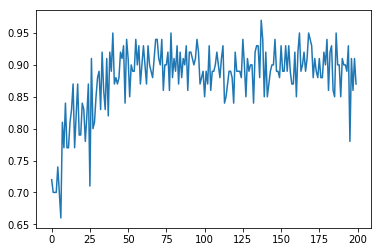

In [32]:
plt.plot(np.arange(0, len(accuracy)), accuracy)

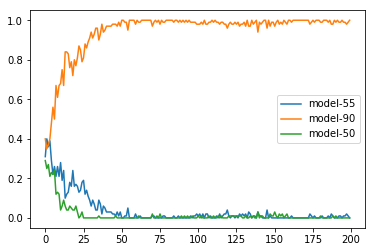

In [35]:
m55, = plt.plot(np.arange(len(model55)),model55, label='model-55')
m90, = plt.plot(np.arange(len(model55)), model90, label='model-90')
m50, = plt.plot(np.arange(len(model55)), model50, label='model-50')
plt.legend(handles=[m55, m90, m50])

In [ ]:
cl.stop_all()